In [1]:
# HYPERPARAMTERS
block=51
batch=64
n_embed=512
iters=40000
# lr=3e-5
n_heads1=8
n_layer=6
dropout=0.1
eval_iters=500
# vocab_size=
factor=4
maxlen=50
#------------------


In [2]:
import torch
import torch.nn.functional as f
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd


In [ ]:
from datasets import load_dataset

raw_datasets = load_dataset("kaitchup/opus-English-to-French")
#raw_datasets.cache_files
for split, dataset in raw_datasets.items():
    dataset.to_csv(f"my-dataset-{split}.csv", index=None)

In [6]:
train=pd.read_csv("my-dataset-train.csv")
val=pd.read_csv('my-dataset-validation.csv')
train[['english','french']]=train['text'].str.split('###>',expand=True)
val[['english','french']]=val['text'].str.split('###>',expand=True)
traininput=train['english'].tolist()
valinput=val['english'].tolist()
trainoutput=train['french'].tolist()
valoutput=val['french'].tolist()
del train,val

In [4]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
inputtokenizertext=str(traininput[:10000])
outputtokenizertext=str(trainoutput[:10000])

In [14]:

# TOKENIZER TRAINING

def check_stats(tokens):

  stats={}
  for i,b in zip(tokens,tokens[1:]):
    stats[(i,b)]=stats.get((i,b),0)+1
  return stats
def merge(ids, pair, idx):
  newids = []
  i = 0
  while i < len(ids):
    if i < len(ids) - 1 and ids[i] == pair[0] and ids[i+1] == pair[1]:
      newids.append(idx)
      i += 2
    else:
      newids.append(ids[i])
      i += 1
  return newids
# len(merge(a))
def createmerge(text,max_vocab):
  tokens=text.encode('utf-8')
  tokens=list(map(int,tokens))
  ids = list(tokens)
  merges={}
  num_merges=max_vocab-255

  for i in range(num_merges):
    stats = check_stats(ids)
    pair = max(stats, key=stats.get)
    idx = 256 + i
    #print(f"merging {pair} into a new token {idx}")
    ids = merge(ids, pair, idx)
    merges[pair] = idx
  return merges


In [15]:
inputmerges=createmerge(inputtokenizertext,1000)
outputmerges=createmerge(outputtokenizertext,1000)
inputvocab = {idx: bytes([idx]) for idx in range(256)}
outputvocab={idx: bytes([idx]) for idx in range(256)}
for (p0, p1), idx in inputmerges.items():
    inputvocab[idx] = inputvocab[p0] + inputvocab[p1]

for (p0, p1), idx in outputmerges.items():
    outputvocab[idx] = outputvocab[p0] + outputvocab[p1]

inputvocab[1001]=b'|padding|'
inputvocab[1002]=b'|eot|'
inputvocab[1003]=b'|start|'
outputvocab[1001]=b'|padding|'
outputvocab[1002]=b'|eot|'
outputvocab[1003]=b'|start|'
inputvocab_size=len(inputvocab)
outputvocab_size=len(outputvocab)

In [20]:
inputvocab[500],outputvocab[600]

(b' that', b'Con')

In [21]:
inputvocab_size,outputvocab_size

(1004, 1004)

In [45]:
# inputfiles={"inputmerges":inputmerges,"inputvocab":inputvocab}
# outputfiles={'outputmerges':outputmerges,"outputvocab":outputvocab}
# inputfile=open("inputfile.dat","wb")
# outputfile=open("outputfile.dat","wb")
# pickle.dump(inputfiles,inputfile)
# pickle.dump(outputfiles,outputfile)
# inputfile.close()
# outputfile.close()

In [22]:
def encode(text,type="input"):
   # given a string, return list of integers (the tokens)
  tokens = list(text.encode("utf-8"))
  if type=='input':
    merges=inputmerges
  else:
    merges=outputmerges
  while len(tokens) >= 2:
    stats = check_stats(tokens)
    pair = min(stats, key=lambda p: merges.get(p, float("inf")))
    if pair not in merges:
      break # nothing else can be merged
    idx = merges[pair]
    tokens = merge(tokens, pair, idx)
  return tokens
def decode(ids,type='input'):
  # given ids (list of integers), return Python string
  if type=='input':
    vocab=inputvocab
  else:
    vocab=outputvocab
  tokens = b"".join(vocab[idx] for idx in ids)
  text = tokens.decode("utf-8", errors="replace")
  return text
#vocab=501


In [24]:
data=[]
for i in ["train","val"]:
  if i =="train":
    inp=traininput
    out=trainoutput
  else:
    inp=valinput
    out=valoutput
  inp1,out1=[],[]
  for r in range(len(inp)):
    # print(r)
    # print(len(encode(inp[r])))
    if len(encode(inp[r],type='input'))<=50 and len(encode(out[r],type='output'))<=50:
      inp1+=[inp[r]]
      out1+=[out[r]]
  data+=[inp1,out1]


In [25]:
traininput1,trainoutput1,valinput1,valoutput1=data

In [ ]:
# decode([1003]+encode(trainoutput1[1],type='output')+[1001]*(maxlen-len(encode(trainoutput1[1],type='outpout')))+[1002],type='output')

In [ ]:

a=[max([len(encode(i)) for i in traininput1]),max([len(encode(i)) for i in trainoutput1]),max([len(encode(i)) for i in valinput1]),max([len(encode(i)) for i in valoutput1])]
b=[len(encode(i)) for i in traininput1]+[len(encode(i)) for i in trainoutput1]+[len(encode(i)) for i in valinput1]+[len(encode(i)) for i in valoutput1]
maxlen=max(a)
maxlen

In [ ]:
len(traininput1),len(trainoutput1),len(valinput1),len(valoutput1)

(7202, 7202, 522, 522)

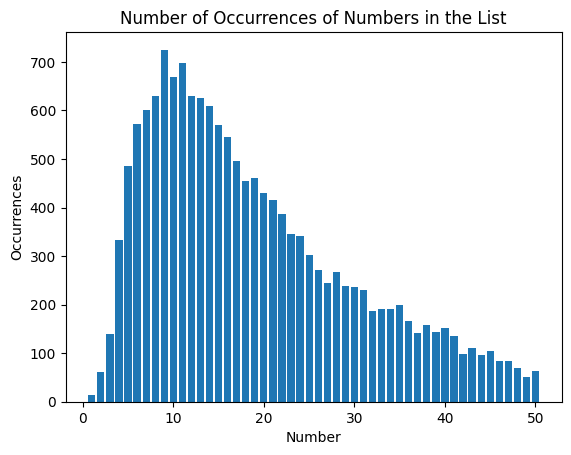

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_occurrences(numbers):
    # Count occurrences of each number in the list
    count = Counter(numbers)

    # Separate keys (numbers) and values (occurrences)
    numbers = list(count.keys())
    occurrences = list(count.values())

    # Plot the data
    plt.bar(numbers, occurrences)

    # Add labels and title
    plt.xlabel('Number')
    plt.ylabel('Occurrences')
    plt.title('Number of Occurrences of Numbers in the List')

    # Show the plot
    plt.show()
plot_occurrences(b)

In [29]:
totraininput=[[1003]+encode(i,type='input')+[1001]*(maxlen-len(encode(i,type='input')))+[1002] for i in traininput1]
totrainoutput=[[1003]+encode(i,type='output')+[1001]*(maxlen-len(encode(i,type='output')))+[1002] for i in trainoutput1]
tovalinput=[[1003]+encode(i,type='input')+[1001]*(maxlen-len(encode(i,type='input')))+[1002] for i in valinput1]
tovaloutput=[[1003]+encode(i,type='output')+[1001]*(maxlen-len(encode(i,type='output')))+[1002] for i in valoutput1]

In [40]:
# a=[totraininput,totrainoutput,tovalinput,tovaloutput]
# import pickle
# file=open("tokenized.dat","wb")
# pickle.dump(a,file)
# file.close()

In [50]:
# len(tovalinput)

1253

In [41]:
# file=open("tokenized.dat","rb")
# a=pickle.load(file)
# totraininput1=a[0]
# decode(totraininput[1],type='input')

'|start|This Regulation shall enter into force on the seventh day following its publication in the Official Journal of the European Union. |padding||padding||padding||padding||padding||padding||padding||padding||padding||padding||eot|'

In [ ]:
# import pickle
# file=open("/content/drive/MyDrive/data_for_translator/tokenizedinputs.dat","rb")
# a=pickle.load(file)
# file.close()
# totrainoutput=a["totraininput"]
# totraininput=a["totrainoutput"]
# tovaloutput=a["tovalinput"]
# tovalinput=a["tovaloutput"]
# file=open("/content/drive/MyDrive/data_for_translator/merges.dat","rb")
# merges=pickle.load(file)
# file.close()
# file=open("/content/drive/MyDrive/data_for_translator/vocab.dat","rb")
# vocab=pickle.load(file)
# file.close()

In [ ]:
def batches(split,batch,block):
  data=[totraininput,totrainoutput] if split=="train" else [tovalinput,tovaloutput]
  ix=torch.randint(len(data[0]),(batch,))
  datain,dataoutput=data[0],data[1]
  din=[datain[i] for i in ix]
  dout=[dataoutput[i] for i in ix]
  xin=torch.stack([torch.tensor(j[1:block]) for j in din])
  xout=torch.stack([torch.tensor(j[2:block+1]) for j in din])
  yin=torch.stack([torch.tensor(j[:block]) for j in dout])
  yout=torch.stack([torch.tensor(j[1:block+1]) for j in dout])
  xin,xout,yin,yout=xin.to(device),xout.to(device),yin.to(device),yout.to(device)
  return xin,xout,yin,yout


In [ ]:
ein,eout,din,dout=batches("train",32,51)
ein.shape,eout.shape,din.shape,dout.shape

(torch.Size([32, 50]),
 torch.Size([32, 50]),
 torch.Size([32, 51]),
 torch.Size([32, 51]))

In [ ]:
class Differentiator(nn.Module):
  def __init__(self,n_embed,heads):
    super().__init__()     #n_embed is the embeddings after matching it with the embedding table and heads is the number of features
    self.key=nn.Linear(n_embed,heads,bias=False)
    self.query=nn.Linear(n_embed,heads,bias=False)
    self.value=nn.Linear(n_embed,heads,bias=False)
  def __call__(self,x):
    key=self.key(x)
    query=self.query(x)
    value=self.value(x)    # B,N,T, HEADS
    return [key,query,value]

In [ ]:
class Multiplier(nn.Module):
  def __init__(self):    #batch, number,  block b,n,t
    super().__init__()

  def __call__(self,k,q,v,n_embed):
      #B,T,HEADS
    key,query=k,q
    wei=query@key.transpose(-2,-1)*(n_embed**-0.5)  #B,N,T,T
    return [wei,v]


In [ ]:
class Masking(nn.Module):
  def __init__(self,block):
    super().__init__()
    self.register_buffer("tril",torch.tril(torch.ones(block,block)))
  def __call__(self,x):
    B,T,C=x.shape
    x=x.masked_fill(self.tril[:T, :T] == 0, float('-inf'))

    return x

In [ ]:
class Head(nn.Module):
  def __init__(self,n_embed,heads,block,dropout,mask=False):
    super().__init__()
    self.n_embed=n_embed
    self.mult=Multiplier()
    self.mask=Masking(block)
    self.maskistrue=mask
    self.dropout=nn.Dropout(dropout)
  def __call__(self,k,q,v):

    wei,v=self.mult(k,q,v,self.n_embed)
    if self.maskistrue:
      wei=self.mask(wei)

    wei=f.softmax(wei,dim=-1)

    wei=self.dropout(wei)
    out =wei @ v
    return out


In [ ]:
class MultipleHead(nn.Module):
  def __init__(self,n_embed,heads,block,dropout,n_heads,mask=False):
    super().__init__()
    self.multihead=nn.ModuleList(Head(n_embed,heads,block,dropout,mask) for _ in range(n_heads))
  def __call__(self,k,q,v):
    return torch.cat([h(k,q,v) for h in self.multihead],dim=-1)



In [ ]:
class FeedForward(nn.Module):
   def __init__(self,n_embed,factor,dropout):    #factor is the ratio of the no of new neurons to the original
      super().__init__()
      self.net=nn.Sequential(nn.Linear(n_embed,factor*n_embed),
                             nn.GELU(),
                             nn.Linear(factor*n_embed,n_embed),
                             nn.Dropout(dropout)
      )
   def __call__(self,x):
        out=self.net(x)
        return out

In [ ]:
class EncoderBlock(nn.Module):
  def __init__(self,n_embed,factor,block,dropout,n_heads):
    super().__init__()
    self.lis=Differentiator(n_embed,n_embed//n_heads)
    self.multihead=MultipleHead(n_embed,n_embed//n_heads,block,dropout,n_heads,mask=False)
    self.ln1=nn.LayerNorm(n_embed)
    self.ffd=FeedForward(n_embed,factor,dropout)
    self.ln2=nn.LayerNorm(n_embed)
  def __call__(self,x):
    a=self.ln1(x)
    k,q,v=self.lis(a)[0],self.lis(a)[1],self.lis(a)[2]
    x=a+self.multihead(k,q,v)
    x=self.ffd(self.ln2(x))+x
    return x

class DecoderBlock(nn.Module):
  def __init__(self,n_embed,factor,block,dropout,n_heads):
    super().__init__()
    self.lis=Differentiator(n_embed,n_embed//n_heads)
    self.lis1=Differentiator(n_embed,n_embed//n_heads)
    self.lis2=Differentiator(n_embed,n_embed//n_heads)
    self.multihead=MultipleHead(n_embed,n_embed//n_heads,block,dropout,n_heads,mask=True)
    self.multihead1=MultipleHead(n_embed,n_embed//n_heads,block,dropout,n_heads,mask=False)
    self.ln1=nn.LayerNorm(n_embed)
    self.ffd=FeedForward(n_embed,factor,dropout)
    self.ln2=nn.LayerNorm(n_embed)
  def __call__(self,c):

    x,encodedata=c
    a=self.ln1(x)
    k,q,v=self.lis(a)[0],self.lis(a)[1],self.lis(a)[2]
    x=a+self.multihead(k,q,v)
    key,value=self.lis1(encodedata)[0],self.lis1(encodedata)[2]
    query=self.lis2(x)[1]
    x=x+self.multihead1(key,query,value)
    x=self.ffd(self.ln2(x))+x
    return [x,encodedata]

In [ ]:

class Model(nn.Module):
  #self,n_embed,factor,block,dropout,n_heads
  def __init__(self,n_embed,factor,block,dropout,n_heads,n_layer):
    super().__init__()
    self.embed1=nn.Embedding(inputvocab_size,n_embed)
    #self.posembed1=positional_encoding(block,n_embed)
    #self.posembed=positional_encoding(block,n_embed)
    self.posembed1=nn.Embedding(block,n_embed)
    self.embed2=nn.Embedding(outputvocab_size,n_embed)
    self.posembed2=nn.Embedding(block,n_embed)
    self.linhead=nn.Linear(n_embed,outputvocab_size)
    self.enc=nn.Sequential(*[EncoderBlock(n_embed=n_embed,n_heads=n_heads,factor=factor,block=block,dropout=dropout) for _ in range(n_layer)])
    self.dec=nn.Sequential(*[DecoderBlock(n_embed=n_embed,n_heads=n_heads,factor=factor,block=block,dropout=dropout) for _ in range(n_layer)])
    self.ln=nn.LayerNorm(n_embed)
    self.ln1=nn.LayerNorm(n_embed)
    self.dropout=nn.Dropout(dropout)
    self.dropout1=nn.Dropout(dropout)
  def __call__(self,encin,decin,decout=None):
    B,T=encin.shape
    b,t=decin.shape

    enctokenembed=self.embed1(encin)  # b,t,cdevice
    encposembed=self.posembed1(torch.arange(T,device=device))
    xenc=enctokenembed+encposembed
    xenc=self.dropout(xenc)
    dectokenembed=self.embed2(decin)  # b,t,c
    decposembed=self.posembed2(torch.arange(t,device=device))

    xdec=dectokenembed+decposembed
    xdec=self.dropout1(xdec)
    encoutput=self.enc(xenc)
    encoutput=self.ln(encoutput)
    del enctokenembed,encposembed,xenc,dectokenembed,decposembed
    decoutput=self.dec([xdec,encoutput])
    decoutput=decoutput[0]
    decoutput=self.ln1(decoutput)

    logits=self.linhead(decoutput)  #b,t,vocab_size
    del decoutput
    b,t,c=logits.shape

    if decout==None:
      loss=None
    else:
      loss=f.cross_entropy(logits.reshape(b*t,-1),decout.reshape(-1))
    return loss,logits
  def generate(self,i):
    ix=torch.ones((1,1),dtype=torch.long,device=device)*1003
    a=torch.tensor([encode(i,type='input')+[1001]*(maxlen-len(encode(i,type='input')))])
    a=a.to(device)
    while ix[-1][-1]!=1002:
      ix_cond=ix[:,-block:]

      loss,logits=self(a,ix_cond)
      # print(logits.shape)
      logits=logits[:,-1,:]
      probs=f.softmax(logits,dim=1)
      #print(probs.shape)
      idx_next=torch.multinomial(probs,num_samples=1)
      #idx_next=idx_next.view(1,-1)
      ix=torch.cat((ix,idx_next),dim=1)

    return ix


In [ ]:

class lr_scheduler():
    def __init__(self,n_embed,warmup_steps=4000):
        self.n_embed=torch.tensor(n_embed,dtype=torch.float64)
        self.warmup_steps=torch.tensor(warmup_steps,dtype=torch.float64)
    def __call__(self,step):
        step=torch.tensor(step,dtype=torch.float64)
        #arg1=torch.sqrt(step)
        #arg2=step * (self.warmup_steps ** -1.5)

        return self.n_embed**-0.5*torch.min(step**-0.5,step*self.warmup_steps**-1.5)




In [ ]:
a=lr_scheduler(n_embed)


In [ ]:
# #most suitable hyperparamters found after sweeping are
# lr=1e-4
# n_embed=256
# n_heads1=16
# n_layer=6
# block=51
# batch=64
# dropout=0.35
# eval_iters=500
# iters=20000
# factor=4

In [ ]:
m=Model(n_embed=n_embed,factor=factor,block=block,n_heads=n_heads1,n_layer=n_layer,dropout=dropout)
#m.load_state_dict(torch.load("/content/drive/MyDrive/data_for_translator/model_val=0.9094.pt"))
m.to(device)

Model(
  (embed1): Embedding(504, 512)
  (posembed1): Embedding(51, 512)
  (embed2): Embedding(504, 512)
  (posembed2): Embedding(51, 512)
  (linhead): Linear(in_features=512, out_features=504, bias=True)
  (enc): Sequential(
    (0): EncoderBlock(
      (lis): Differentiator(
        (key): Linear(in_features=512, out_features=64, bias=False)
        (query): Linear(in_features=512, out_features=64, bias=False)
        (value): Linear(in_features=512, out_features=64, bias=False)
      )
      (multihead): MultipleHead(
        (multihead): ModuleList(
          (0-7): 8 x Head(
            (mult): Multiplier()
            (mask): Masking()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ffd): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=2048

In [ ]:
from tqdm import tqdm
@torch.no_grad()
def estimate_loss(batch,block,eval_iters,model):
  out={}
  model.eval()
  print("estimating loss using functino")
  for split in ['train','val']:

    losses=torch.zeros(eval_iters)
    for k in tqdm(range(eval_iters)):
      ein,eout,din,dout=batches(split,batch,block)
      loss,logits=model(ein,din,dout)
      losses[k] =loss.item()
    out[split]=losses.mean()
    print(out[split]," ",split)
  print(out)
  model.train()
  return out


In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import pylab as pl
from IPython import display
def training(lossl=None):
  if lossl==None:
    lossl=[]
  else:
    lossl=lossl
  print("running on ",device)
  for steps in tqdm(range(40000,80000)):
    ein,eout,din,dout=batches("train",batch=batch,block=block)
    lr=a(steps)
    optimizer = torch.optim.AdamW(m.parameters(), lr=lr,betas=(0.9,0.98),eps=1e-9)
    loss,logits=m(ein,din,dout)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    lossl+=[loss.item()]
    # if steps%eval_iters==0 or steps==iters-1:
    #    estimate_loss(batch,block,eval_iters,m)
    if steps%5000==0:
      torch.save(m.state_dict(), f"/content/drive/MyDrive/data_for_translator/model{steps}.pt")

    if steps%200==0 or steps==80000-1:

      pl.plot(range(len(lossl)),lossl,color="red")
      pl.axhline(y=1, color='b', linestyle='--')
      display.clear_output(wait=True)
      display.display(pl.gcf())
  torch.save(m.state_dict(), f"/content/drive/MyDrive/data_for_translator/model{steps}.pt")
  return lossl


In [ ]:
losses=[]

In [ ]:
estimate_loss(batch,block,eval_iters,m)

estimating loss using functino


100%|██████████| 500/500 [00:44<00:00, 11.20it/s]


tensor(0.7248)   train


100%|██████████| 500/500 [00:39<00:00, 12.72it/s]

tensor(0.9094)   val
{'train': tensor(0.7248), 'val': tensor(0.9094)}


{'train': tensor(0.7248), 'val': tensor(0.9094)}

In [ ]:
raw=m.generate("How are you doing today?")[-1].tolist()
raw=[i for i in raw if i not in [502,501,503]]
decode(raw)

'Veuillez me prononc.", \'les enfof the s ?'

In [ ]:
sum(p.numel() for p in m.parameters())

28409336

In [ ]:
# a={"totraininput":totraininput,"totrainoutput":totrainoutput,"tovalinput":tovalinput,"tovaloutput":tovaloutput}

In [ ]:
# a={"traininput":traininput1,"trainoutput":trainoutput1,"valinput":valinput1,"valoutput":valoutput1}

In [ ]:
# import pickle
# file=open("trimmedinputs.dat","wb")
# pickle.dump(a,file)
# file.close()

In [ ]:
# steps=53
# torch.save(m.state_dict(), f"/content/model_val=0.9094.pt")

In [ ]:
torch.save(m.state_dict(), "/content/model2.pt")

In [ ]:
#{'train': tensor(0.7658), 'val': tensor(1.4724)} when lr=3e-4 and embed is 256 iter= 2000 b=64
#{'train': tensor(1.2398), 'val': tensor(1.5915)} when lr =2e-4 and embed is 128 iter =2000 b=32
#{'train': tensor(1.1645), 'val': tensor(1.5469)} wehn lr =3e-4 and embed is 128 iter=2000 b=32
#{'train': tensor(0.5140), 'val': tensor(1.5265)} when lr =3e-4 and embed is 256 iter =4000 b=64 overfit ho rha h yha


In [ ]:
# import pickle

# vocabreader=open('vocab.dat','rb')
# mergesreader=open('merges.dat','rb')
# vocab=pickle.load(vocabreader)
# merges=pickle.load(mergesreader)
# vocab_size=len(vocab)

In [ ]:
import wandb
wandb.login()

sweep_config={
    'method':'random'
}

metric={
    'name':'loss',
    'goal':'minimize'

}

parameters_dict={
    'batch':{
        'values':[32,64,128]
    },
    'n_embed':{
    'values':[32,64,128,512]
    },
    'n_heads':{
        "values":[8,16]
    },
    'n_layers':{
        'values':[4,6,8,10,12]
    },
    'dropout':{
        'values':[0.2,0.3,0.35,0.4]
    },
    'factor':{
        'values':[4,8]
    },
    'lr':{
        'values':[4e-5,8e-5,1,1e-4,3e-4,7e-4,3e-3,1e-3]
    }


}

parameters_dict.update({
    'iters':{'value':2000},
    'block':{'value':51},
    'eval_iters':{"value":500}

})
sweep_config['parameters']=parameters_dict
sweep_config['metric']=metric

In [ ]:
import pprint
pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'batch': {'values': [32, 64, 128]},
                'block': {'value': 51},
                'dropout': {'values': [0.2, 0.3, 0.35, 0.4]},
                'eval_iters': {'value': 500},
                'factor': {'values': [4, 8]},
                'iters': {'value': 2000},
                'lr': {'values': [4e-05,
                                  8e-05,
                                  1,
                                  0.0001,
                                  0.0003,
                                  0.0007,
                                  0.003,
                                  0.001]},
                'n_embed': {'values': [32, 64, 128, 512]},
                'n_heads': {'values': [8, 16]},
                'n_layers': {'values': [4, 6, 8, 10, 12]}}}


In [ ]:
from tqdm import tqdm
def training(config=None):
  with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        #loader = build_dataset(config.batch_size)
        m=Model(n_embed=config.n_embed,factor=config.factor,block=config.block,n_heads=config.n_heads,n_layer=config.n_layers,dropout=config.dropout)
        m.to(device)
        #network = build_network(config.fc_layer_size, config.dropout)
        optimizer = torch.optim.AdamW(m.parameters(), lr=config.lr)
        #optimizer = torch.optim.AdamW(config.optimizer, confi "epoch": epochg.learning_rate)
        cum=[]
        for epoch in tqdm(range(config.iters)):
             ein,eout,din,dout=batches("train",batch=config.batch,block=config.block)
             loss,logits=m(ein,din,dout)
             optimizer.zero_grad(set_to_none=True)
             loss.backward()
             cum+=[loss.item()]
             optimizer.step()
        cum=torch.tensor(cum,dtype=torch.float)
        avgloss=cum.mean()
        a=estimate_loss(batch=config.batch,block=config.block,eval_iters=config.eval_iters,model=m)
        wandb.log({"avgtrainingloss":avgloss,"loss":float(a['val']),"trainloss":float(a['train'])})

        #
        #print(a)
            #  avg_loss = train_epoch(network, loader, optimizer)
        # wandb.log({"loss": float(a['val'])})
sweep_id = wandb.sweep(sweep_config)

Create sweep with ID: 70wa861c
Sweep URL: https://wandb.ai/abhyudayhari/uncategorized/sweeps/70wa861c


In [ ]:
a=[i for i in range(10)]
print(a)
a=torch.tensor(a,dtype=torch.float)
print(a.mean())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
tensor(4.5000)


In [ ]:
wandb.agent(sweep_id,training,count=100)

In [ ]:
a=m.generate("Hi what were you doing yesterday")[-1].tolist()
a=[i for i in a if i not in [502,501,503]]
decode(a)